Finalizada a fase de diagnóstico, responder como e onde atuar para reducao das consultas, com menos impacto nas digitacoes.

Utilizar métodos estatísticos para variáveis discretas não negativas.

Agrupas os dados por clicos:

- ciclo de consulta 18h - 9h

- clico de digitação 9h - 18h

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pylab as plt

In [2]:
dados = pd.read_csv('../../output_data/datasets/all_data.csv')

In [3]:
dados.columns

Index(['id_pagas', 'date_pagas', 'undefined_pagas', 'CPF_pagas',
       'provider_pagas', 'contrato_pagas', 'partiner_pagas', 'proventos_pagas',
       'tabela', 'id_consulta', 'provider_consulta', 'CPF_consulta',
       'status_consulta', 'provider_key_consulta', 'created_consulta',
       'update_consulta', 'partiner_consulta', 'message_consulta', 'CPF_storm',
       'ADE', 'CMSRepassada'],
      dtype='object')

In [4]:
teste = dados[['created_consulta', 'status_consulta', 'CPF_consulta', 'CPF_pagas']]

In [5]:
teste['consulta_finalizada'] = 0

In [6]:
teste.loc[(teste.status_consulta == 'completed') & (teste.CPF_pagas.notna()), 'consulta_finalizada'] = 1

In [7]:
teste['consulta_finalizada'].sample(10).values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [8]:
for cpf in teste.loc[teste.consulta_finalizada == 1, 'CPF_consulta'].unique():
    indices = teste[teste.CPF_consulta == cpf].index
    teste.loc[indices[0], 'consulta_finalizada'] = 1
    teste.loc[indices[1:], 'consulta_finalizada'] = 0


In [9]:
teste.sort_values(by='created_consulta', inplace=True)

In [10]:
teste['hora'] = pd.to_datetime(teste['created_consulta']).dt.hour
teste['data'] = pd.to_datetime(teste['created_consulta']).dt.date

In [11]:
teste['ciclo'] = np.where(teste['hora'].isin([18, 19, 20, 21, 22, 23, 24, 0, 1, 2, 3, 4, 5, 6, 7, 8]), 'noturno', 'diurno')

In [12]:
teste.ciclo.value_counts()

ciclo
noturno    1521769
diurno      764840
Name: count, dtype: int64

In [13]:
finalizadas = teste[teste.consulta_finalizada == 1]
nao_finalizadas = teste[teste.consulta_finalizada != 1]

In [14]:
finalizadas = pd.DataFrame(finalizadas[['data', 'ciclo']].groupby(by=['data', 'ciclo']).size())

In [15]:

nao_finalizadas = pd.DataFrame(nao_finalizadas[['data', 'ciclo']].groupby(by=['data', 'ciclo']).size())

In [16]:
finalizadas.reset_index(inplace=True)
nao_finalizadas.reset_index(inplace=True)

In [17]:
finalizadas.columns = ['data_f', 'ciclo_f', 'qtd_finalizadas']
nao_finalizadas.columns = ['data_n', 'ciclo_n', 'qtd_nao_finalizadas']

In [18]:
agregado = pd.concat([finalizadas, nao_finalizadas], axis=1)

In [19]:
agregado.drop(['data_n', 'ciclo_n'], axis = 1, inplace=True)

In [20]:
import seaborn as sns

In [21]:
agregado.sample(5)

,data_f,ciclo_f,qtd_finalizadas,qtd_nao_finalizadas
14,2025-09-08,diurno,248,29582
49,2025-09-26,noturno,27,49190
24,2025-09-13,diurno,76,34420
32,2025-09-17,diurno,98,25699
51,2025-09-27,noturno,7,46815


In [22]:
agregado['conversao'] = agregado['qtd_finalizadas'] / agregado['qtd_nao_finalizadas']

<Axes: xlabel='qtd_nao_finalizadas', ylabel='qtd_finalizadas'>

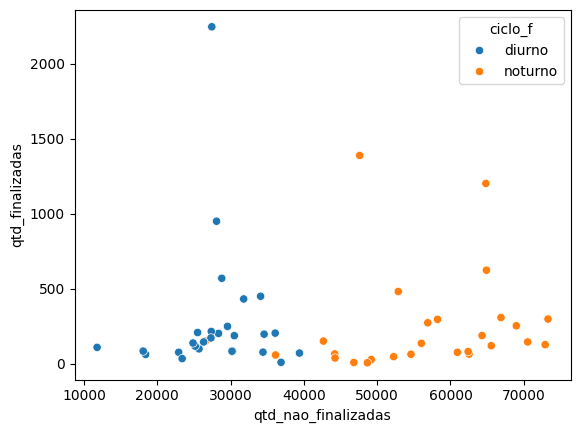

In [23]:
sns.scatterplot(data=agregado, x = 'qtd_nao_finalizadas', y = 'qtd_finalizadas', hue='ciclo_f')

In [24]:
agregado['Total_Consultas'] = agregado['qtd_finalizadas'] + agregado['qtd_nao_finalizadas']

In [25]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [26]:
# --- 3. Ajustar Modelo Binomial Negativo com Offset (Modelo de Taxa) ---
negbin_rate_model = smf.glm(
    # Formula sem preditores, apenas o intercepto (1)
    formula="qtd_finalizadas ~ 1", 
    data=agregado,
    family=sm.families.NegativeBinomial(),
    # log(Total_Consultas) é o nosso offset
    exposure=agregado['Total_Consultas'] 
).fit()

print("\n--- Modelo Binomial Negativa (Modelo de Taxa) ---")
print(negbin_rate_model.summary())


--- Modelo Binomial Negativa (Modelo de Taxa) ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:        qtd_finalizadas   No. Observations:                   54
Model:                            GLM   Df Residuals:                       53
Model Family:        NegativeBinomial   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -356.76
Date:                Thu, 06 Nov 2025   Deviance:                       75.203
Time:                        13:55:34   Pearson chi2:                     144.
No. Iterations:                     6   Pseudo R-squ. (CS):              0.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
I

c:\Users\FagnerFarias\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [27]:
np.exp(-4.9656)

np.float64(0.006973765194454684)

In [28]:
agregado.qtd_finalizadas.sum() / agregado.qtd_nao_finalizadas.sum()

np.float64(0.006204595889389217)

In [29]:
df = agregado
df

,data_f,ciclo_f,qtd_finalizadas,qtd_nao_finalizadas,conversao,Total_Consultas
0,2025-09-01,diurno,2248,27442,0.081918,29690
1,2025-09-01,noturno,1389,47618,0.029170,49007
2,2025-09-02,diurno,950,28088,0.033822,29038
3,2025-09-02,noturno,1202,64828,0.018541,66030
4,2025-09-03,diurno,431,31792,0.013557,32223
5,2025-09-03,noturno,481,52877,0.009097,53358
6,2025-09-04,diurno,569,28800,0.019757,29369
7,2025-09-04,noturno,623,64902,0.009599,65525
8,2025-09-05,diurno,449,34098,0.013168,34547
9,2025-09-05,noturno,295,58236,0.005066,58531


In [30]:
df.to_csv("df.csv", index=False)

In [31]:
negbin_rate_model.save("negbin_model.pkl")

In [ ]:
TAXA_CONVERSAO = 1
MCU = -27.17
CUSTO_CONSULTA = 0.25
LIMIAR = 0.001
dados = pd.DataFrame({
    "consulta": np.linspace(1000, 75000, 100)
})
dados['custo'] = dados["consulta"] * CUSTO_CONSULTA
dados["mcu"] = round((dados["consulta"] * TAXA_CONVERSAO) * MCU, 2)
dados["dif"] = round(dados["mcu"] - dados["custo"].shift(), 2)
dados["retorno_dif"] = round(dados["dif"] / dados["dif"].shift(), 2)
dados['retorno_dif'] = dados['retorno_dif']

In [37]:
dados

,consulta,custo,mcu,dif,retorno_dif
0,1000.000000,250.000000,8600.00,NaN,NaN
1,1747.474747,436.868687,15028.28,14778.28,NaN
2,2494.949495,623.737374,21456.57,21019.70,1.42
3,3242.424242,810.606061,27884.85,27261.11,1.30
4,3989.898990,997.474747,34313.13,33502.52,1.23
...,...,...,...,...,...
95,72010.101010,18002.525253,619286.87,601471.21,1.01
96,72757.575758,18189.393939,625715.15,607712.62,1.01
97,73505.050505,18376.262626,632143.43,613954.04,1.01
98,74252.525253,18563.131313,638571.72,620195.46,1.01


Ponto onde a curva perde inclinação (platô): 15949.494949494949


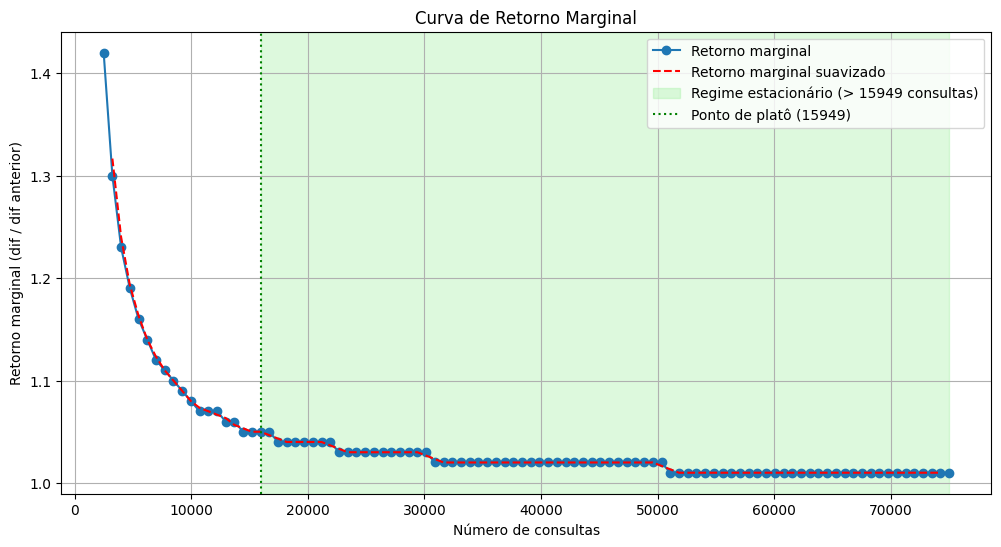

In [33]:

# derivada discreta
dados['delta_ret_marginal'] = dados['retorno_dif'].diff().abs()

# Calcula a derivada discreta
dados['delta_ret_marginal'] = dados['retorno_dif'].diff().abs()

# Suaviza a curva para reduzir ruídos
dados['retorno_dif_smooth'] = dados['retorno_dif'].rolling(window=3, center=True).mean()
dados['delta_ret_marginal_smooth'] = dados['retorno_dif_smooth'].diff().abs()
dados = dados.iloc[2:, :]
# Detecta o ponto do platô
platô = dados[dados['delta_ret_marginal_smooth'] < LIMIAR]
ponto_platô = platô.iloc[0]['consulta']
print("Ponto onde a curva perde inclinação (platô):", ponto_platô)

# Plotagem
plt.figure(figsize=(12,6))
plt.plot(dados['consulta'], dados['retorno_dif'], marker='o', label='Retorno marginal')
plt.plot(dados['consulta'], dados['retorno_dif_smooth'], color='red', linestyle='--', label='Retorno marginal suavizado')

# Destaca a região do platô
plt.axvspan(ponto_platô, dados['consulta'].max(), color="lightgreen", alpha=0.3, label=f"Regime estacionário (> {int(ponto_platô)} consultas)")

# Pontos de referência
plt.axvline(x=ponto_platô, color='green', linestyle=':', label=f'Ponto de platô ({int(ponto_platô)})')

# Labels e título
plt.xlabel("Número de consultas")
plt.ylabel("Retorno marginal (dif / dif anterior)")
plt.title("Curva de Retorno Marginal")
plt.legend()
plt.grid(True)


In [34]:
estavel = dados[dados["consulta"] > 10000]
variacao_media = estavel["retorno_dif"].diff().abs().mean()
print("Variação média do retorno marginal após 10k consultas:", variacao_media)


Variação média do retorno marginal após 10k consultas: 0.0006976744186046518


In [35]:
estavel = dados[dados["consulta"] < 10000]
variacao_media = estavel["retorno_dif"].diff().abs().mean()
print("Variação média do retorno marginal após 10k consultas:", variacao_media)


Variação média do retorno marginal após 10k consultas: 0.03399999999999999
